In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df.head(), df.shape

(                  Date  Price  FR Generation  FR Load
 0  2018-01-01 00:00:00   4.74        53625.0  56250.0
 1  2018-01-01 01:00:00   3.66        52398.0  54300.0
 2  2018-01-01 02:00:00   1.26        51825.0  53600.0
 3  2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4  2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 (43824, 4))

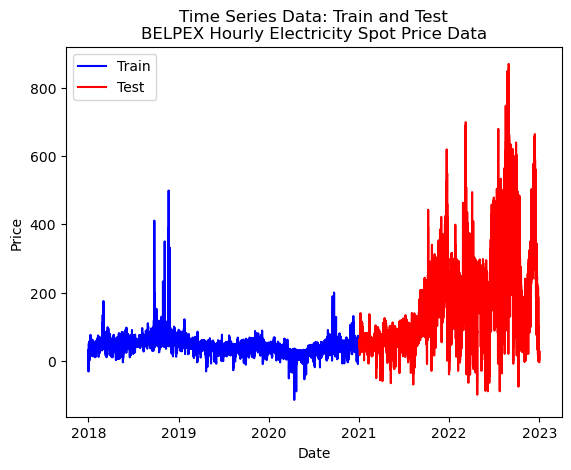

In [19]:
df["Date"] = pd.to_datetime(df["Date"])

train_df = df[df['Date'] < '2021-01-01']
test_df = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2022-12-31 23:00:00')]


# Plot train dataset in blue
plt.plot(train_df["Date"], train_df["Price"], color='blue', label='Train')

# Plot test dataset in red
plt.plot(test_df["Date"], test_df["Price"], color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Time Series Data: Train and Test\nBELPEX Hourly Electricity Spot Price Data')
plt.show()

In [31]:
train_df.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=26304, freq=None)

In [20]:
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)

In [21]:
train_df = train_df["Price"]
test_df = test_df["Price"]
train_data = train_df.values.reshape(-1, 1)
test_data = test_df.values.reshape(-1, 1)
train_data.shape, test_data.shape

((26304, 1), (17520, 1))

In [22]:
# scale the data
#IS IT OKAY TO TRANSFORM TEST DATASETSET WITH SCALER FITTED ON TRAIN DATA
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [42]:
# generate the input and output sequences for training data
n_lookback = 168  # length of input sequences (lookback period), 7*24H
n_forecast = 24  # length of output sequences (forecast period), 24H

X_train = []
Y_train = []

# This loop is designed to ensure that we can extract enough input-output pairs from the time series data
for i in range(0, len(train_data_scaled) - n_lookback - n_forecast + 1, 24):
    X_train.append(train_data_scaled[i:i + n_lookback])  # Append a subsequence of length n_lookback from the y dataset
    Y_train.append(train_data_scaled[i + n_lookback:i + n_lookback + n_forecast])  # Corresponding output sequence

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [43]:
# generate the input sequences for test data
X_test = []

# Iterate through the data with a step size of 24 hours
for i in range(0, len(test_data_scaled) - n_lookback + 1, 24):
    X_test.append(test_data_scaled[i:i + n_lookback])

X_test = np.array(X_test)

In [49]:
X_test.shape

(724, 168, 1)

In [45]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=100)



Epoch 1/100

Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch

In [46]:
Y_pred_scaled = model.predict(X_test)

23/23 [==============================] - 1s 22ms/step


In [47]:
# Inverse scaling
Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)) #reshape to get column vector!
Y_actual = test_data[n_lookback:].flatten()

In [51]:
Y_pred[:-24].shape, Y_actual.shape

((17352, 1), (17352,))

In [55]:
Y_pred

array([[46.984276 ],
       [43.515007 ],
       [43.68319  ],
       ...,
       [11.95144  ],
       [13.0151   ],
       [ 7.8057404]], dtype=float32)

In [62]:
from sklearn.metrics import mean_absolute_error as mae

mae = mae(Y_actual, Y_pred[:-24].flatten())

# mae_trend = []
# for i in range(1,Y_actual.shape[0]-28):
#     if i == 1:
#         mae_trend.append(mae(Y_actual[0:30],Y_pred[0:30*i]))
#         continue
#     current_actual = Y_actual[i-1:30+(i-1)]
#     current_predicted = Y_pred[30*(i-1):30*i]
#     mae_trend.append(mae(current_actual,current_predicted))
#     # print(Y_actual[i-1:30+(i-1)].shape, Y_pred[30*(i-1):30*i].shape)

In [78]:
x_ticks = test_df.index[:-168]
x_ticks.shape, Y_actual.shape, Y_pred.shape

((17352,), (17352,), (17376, 1))

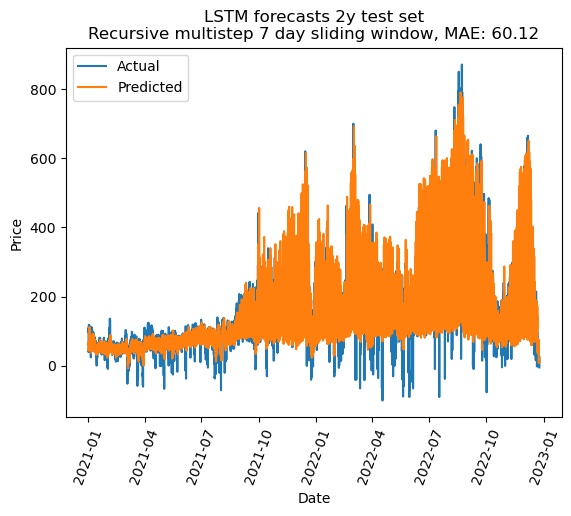

In [83]:
x_ticks = test_df.index[:-168]

plt.plot(x_ticks, Y_actual, label="Actual")
plt.plot(x_ticks, Y_pred[:-24], label="Predicted")
plt.title(f"LSTM forecasts 2y test set\nRecursive multistep 7 day sliding window, MAE: {round(mae,2)}")
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()